In [1]:
from tidyverse.dummy import *
import scanpy as sc
import sys
sys.path.append('..')
plt.rcParams["figure.figsize"] = (4,3)

import decoupler as dc
from matplotlib_inline.backend_inline import set_matplotlib_formats
from colormaps import color_dict_coarse_celltype, color_dict_diagnosis
from ecm_de_data import load_ECM_M_vs_T, load_ECM_NE_vs_M, load_ECM_NE_vs_T, cmap_updown

plt.ion()

import sys
sys.path.append('..')
from util import load_merged_data

Importing tidyverse


In [2]:
plotfolder = '/tmp/ECM_NE_vs_M'
import os
if not os.path.exists(plotfolder):
    os.mkdir(plotfolder)

In [3]:
df_NE_vs_M = load_ECM_NE_vs_M()
df_NE_vs_M['Pvalue_clipped'] = np.clip(df_NE_vs_M['Pvalue'] , 1e-50,  1)
df_NE_vs_M.shape

(1562, 8)

In [4]:
df_NE_vs_M.head()

,log2fc,qvalue,gene,Comparison (group1/group2),# of Ratios,Pvalue,up_or_down,Pvalue_clipped
0,-1.52,0.163,RBM47,M / MaN,20,0.0775,nonsig,0.0775
1,-1.52,0.531,UBA6,M / MaN,35,0.6280,nonsig,0.6280
2,-4.83,0.216,ESYT2,M / MaN,25,0.1220,nonsig,0.1220
3,-0.45,0.589,ILVBL,M / MaN,15,0.7820,nonsig,0.7820
4,-0.44,0.628,NBAS,M / MaN,25,0.8990,nonsig,0.8990


/tmp/ipykernel_195462/3507434027.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


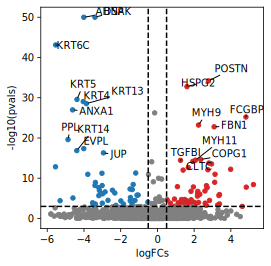

/tmp/ipykernel_195462/3507434027.py:4: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


In [5]:
set_matplotlib_formats('svg')
dc.plot_volcano_df(df_NE_vs_M.set_index('gene'), x='log2fc', y='Pvalue_clipped', sign_thr=0.001, top=20, lFCs_limit=6, figsize=(4,4), save=f'{plotfolder}/volcano.svg')
plt.show()
set_matplotlib_formats('png')

# sc

In [6]:
genes_up = sorted(df_NE_vs_M.query('qvalue<0.001 and log2fc>0.58').gene.values)
genes_down = sorted(df_NE_vs_M.query('qvalue<0.001 and log2fc<-0.58').gene.values)

In [7]:
" ".join(genes_up)

'ACTN4 AGR2 ATP1A1 CLTC COL4A1 COL4A2 COPA COPG1 EEF1A1 EMILIN1 EPX ETHE1 FBN1 FCGBP FLNA HSP90B1 HSPG2 IGHA2 KRT2 KRT9 LAMA5 LAMB1 LAMC1 LGALS3 LGALS4 LRPPRC MDH2 MUC2 MYH11 MYH9 MYO1D PLS1 POSTN PRG2 QARS1 SND1 TGFBI TLN1 VPS51'

In [8]:
" ".join(genes_down) 

'AHNAK ANXA1 APOB CAMK2D COL7A1 CRYBG1 CTNND1 DES DSC2 DSG1 DSP ECM1 EPPK1 EVPL FAM83H FLNC HSPB1 JUP KRT1 KRT13 KRT14 KRT15 KRT16 KRT17 KRT19 KRT4 KRT5 KRT6A KRT6B KRT6C KRT77 KRT78 KRT80 NES PKP3 PPL S100A11 SPTB SPTBN2 TUBA4A TUBB6'

# Analysis

In [9]:
ECM_diagnosis = ["NE", "M"]

In [10]:
from util import load_merged_data

In [11]:
A = load_merged_data()

# add CNV calls
df_cnv = pd.read_csv('/users/mstrasse/CRUK-code/notebooks/CNVs/O_full.csv', index_col=0)
A.obs.index = A.obs.index.map(lambda x: '-'.join(x.split('-')[:2]))
A.obs = A.obs.merge(df_cnv[['cnv_celltype_split','has_cnv','cnv_avg','cnv_leiden', 'cnv_score', 'ss']], left_index=True, right_index=True, how='left')
A.obs.cnv_leiden = pd.Categorical(A.obs.cnv_leiden)

/tmp/ipykernel_195462/2650541956.py:4: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.


In [12]:
ECM_patients = ["EV02","E14","E20", "E21","E24"]

In [13]:
A = A[A.obs.patient.isin(ECM_patients)]
A = A[A.obs.diagnosis.isin(ECM_diagnosis)].copy()
A.raw = A

In [14]:
cluster_order = [
    'Columnar Epithelium', 
    'Squamous Epithelium',
    'Bcells', 
    'Tcells',
    'Mast cells', 
    'Myeloid',
    'Endothelial cells', 
    'Fibroblasts',
    'Myofibroblasts',
    'Other'
]

A.obs.celltype_split = pd.Categorical(A.obs.celltype_split, cluster_order)

In [15]:
# recolor(A, 'celltype_split', color_dict_coarse_celltype)

In [16]:
A.obs['celltype_split_cnv_augmented'] = A.obs['celltype_split'].astype(str)
A.obs.loc[A.obs.query('celltype_split=="Columnar Epithelium" and has_cnv=="yes"').index, 'celltype_split_cnv_augmented'] = "Columnar Epithelium (CNV+)"
A.obs.loc[A.obs.query('celltype_split=="Columnar Epithelium" and has_cnv=="no"').index, 'celltype_split_cnv_augmented'] = "Columnar Epithelium (CNV-)"

_c = ['Columnar Epithelium (CNV-)', 'Columnar Epithelium (CNV+)', 'Squamous Epithelium', 'Bcells', 'Tcells', 'Mast cells', 'Myeloid', 'Endothelial cells', 'Fibroblasts',  'Myofibroblasts', 'Other']
A.obs.celltype_split_cnv_augmented = pd.Categorical(A.obs.celltype_split_cnv_augmented, _c) 

pd.crosstab(A.obs.celltype_split_cnv_augmented, A.obs.has_cnv)

has_cnv,no,yes
celltype_split_cnv_augmented,,
Columnar Epithelium (CNV-),4209,0
Columnar Epithelium (CNV+),0,432
Squamous Epithelium,2244,11
Bcells,586,0
Tcells,2318,0
Mast cells,628,0
Myeloid,678,0
Endothelial cells,1501,0
Fibroblasts,1171,0


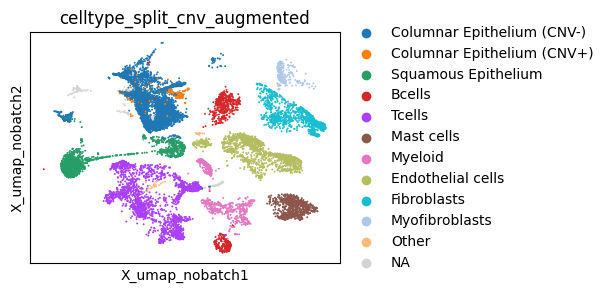

In [17]:
sc.pl.embedding(A, basis='X_umap_nobatch', color=['celltype_split_cnv_augmented'])

# NE vs M differential expression

## ECM-DE vs clusters

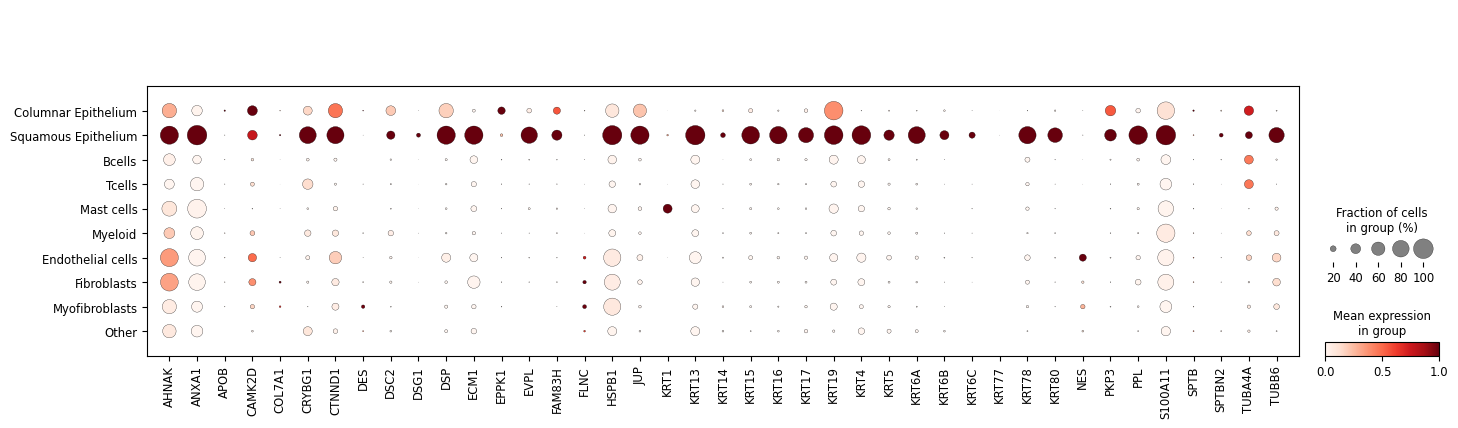

In [18]:
sc.pl.dotplot(A, var_names=genes_down, groupby='celltype_split', standard_scale='var', dendrogram=False, show=False)
plt.savefig(f'{plotfolder}/ECM_singlecellsource_downreg.svg')

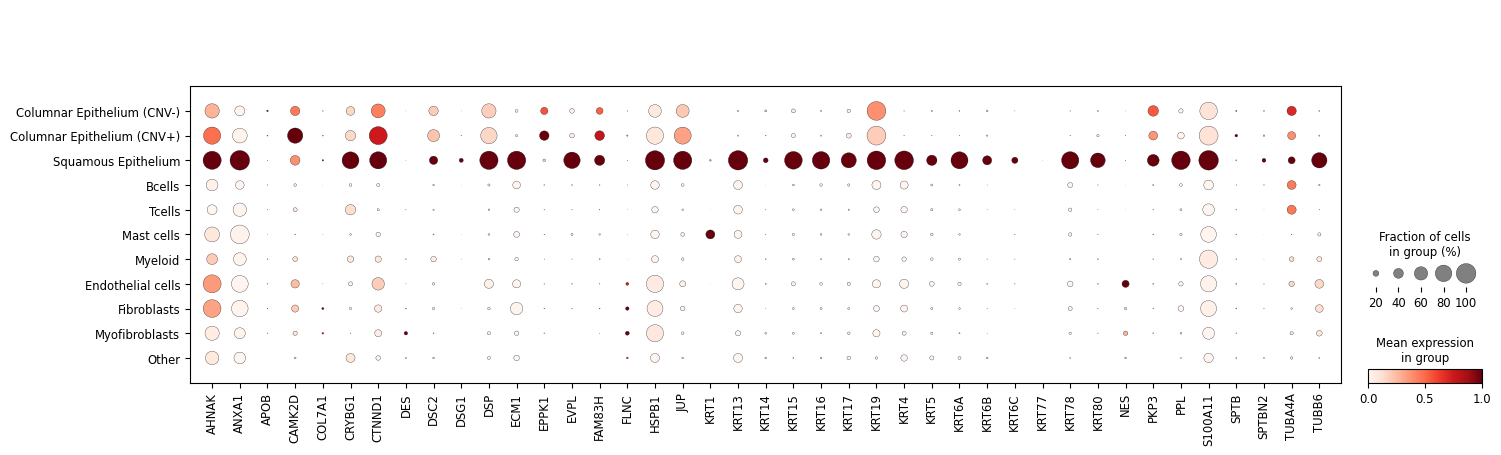

In [19]:
sc.pl.dotplot(A, var_names=genes_down, groupby='celltype_split_cnv_augmented', standard_scale='var', dendrogram=False, show=False)
plt.savefig(f'{plotfolder}/ECM_singlecellsource_downreg.svg')

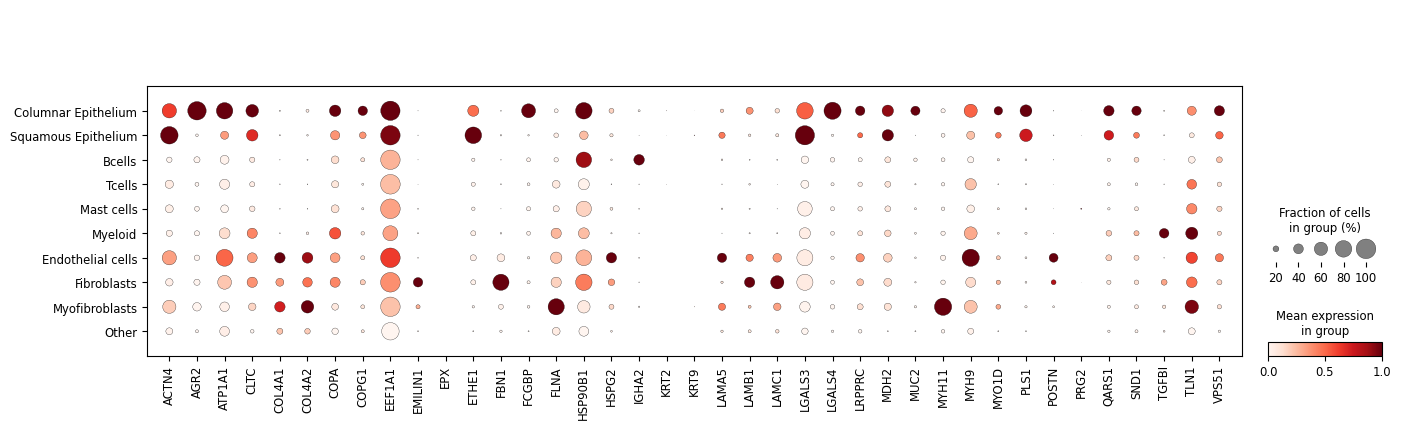

In [20]:
sc.pl.dotplot(A, var_names=genes_up, groupby='celltype_split', standard_scale='var', dendrogram=False, show=False)
plt.savefig(f'{plotfolder}/ECM_singlecellsource_upreg.svg')

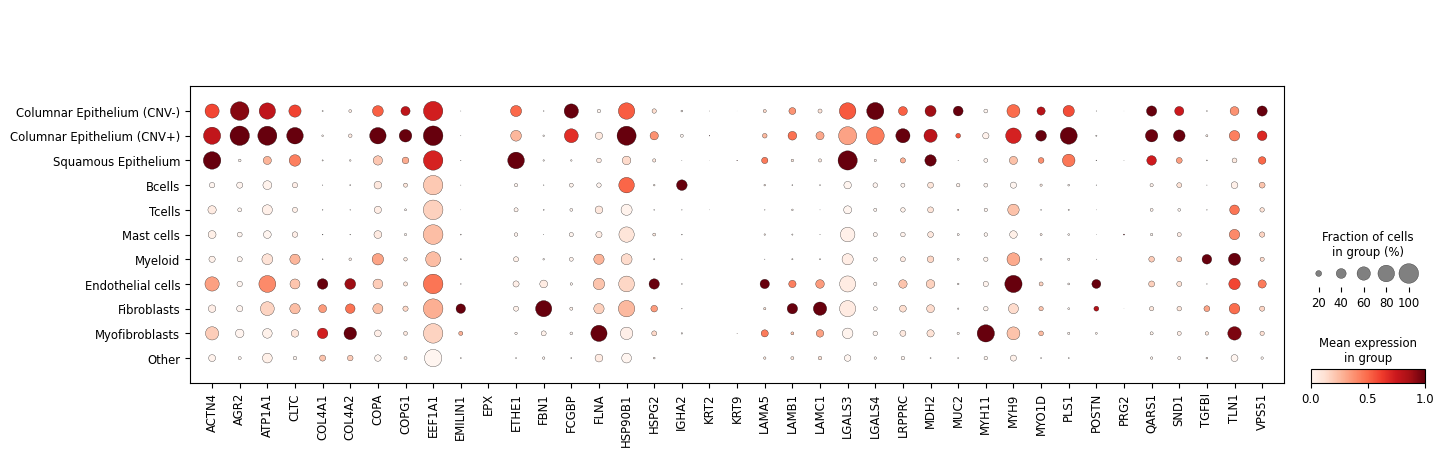

In [21]:
sc.pl.dotplot(A, var_names=genes_up, groupby='celltype_split_cnv_augmented', standard_scale='var', dendrogram=False, show=False)
plt.savefig(f'{plotfolder}/ECM_singlecellsource_upreg.svg')

In [22]:
_d = A.obs.groupby(['celltype_split_cnv_augmented','diagnosis']).samplename.count().reset_index().rename({'samplename': 'n_cells'}, axis=1)
celltype_total = _d .groupby('celltype_split_cnv_augmented').n_cells.sum().to_dict()
_d['total'] = _d.celltype_split_cnv_augmented.apply(lambda x: celltype_total[x]).astype(int)
_d['percent_cells'] = _d.n_cells / _d.total
# reverse order so it works in the flipped diagram
_d['celltype_split_cnv_augmented'] = pd.Categorical(_d['celltype_split_cnv_augmented'] , _d['celltype_split_cnv_augmented'].cat.categories[::-1])
_d.head()

/tmp/ipykernel_195462/1318121404.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/tmp/ipykernel_195462/1318121404.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,celltype_split_cnv_augmented,diagnosis,n_cells,total,percent_cells
0,Columnar Epithelium (CNV-),M,4165,4209,0.989546
1,Columnar Epithelium (CNV-),NE,44,4209,0.010454
2,Columnar Epithelium (CNV+),M,432,432,1.000000
3,Columnar Epithelium (CNV+),NE,0,432,0.000000
4,Squamous Epithelium,M,83,2256,0.036791


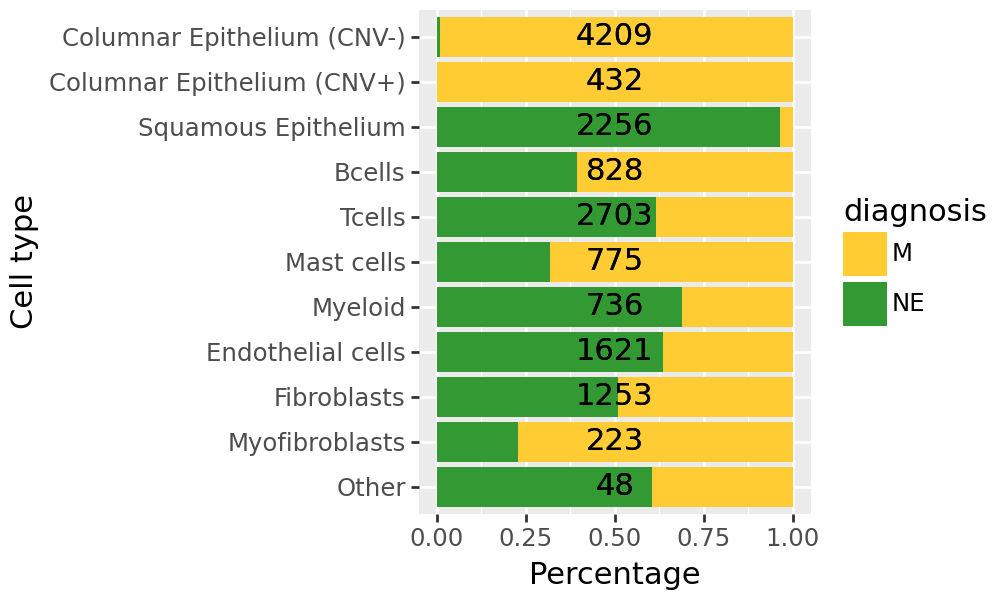

In [23]:
pn.ggplot(_d) +pn.aes(x='celltype_split_cnv_augmented', fill='diagnosis', y='percent_cells') + pn.geom_bar(stat='identity') \
+ pn.geom_text(data=_d, mapping=pn.aes( x='celltype_split_cnv_augmented', y=0.5, label='total')) \
+ pn.coord_flip()+pn.theme(figure_size=(5,3)) + pn.labs(y='Percentage', x='Cell type') + pn.scale_fill_manual(color_dict_diagnosis)

# General fold change in proteomics vs scrnaseq 
independent of cell type etc

In [24]:
from ecm_tools import fold_change_pseudobulk_fixed
import decoupler as dc

adata_bulk_de = dc.get_pseudobulk(
        A,
        sample_col='samplename', 
        groups_col=None,
        use_raw=False,
        mode='sum',
        min_cells=0,
        # min_counts=10000,
    )
adata_bulk_de.raw  = adata_bulk_de

In [25]:
_FC_pseudobulk_df =  fold_change_pseudobulk_fixed(adata_bulk_de, gene_list=genes_up+genes_down, diagnosis1="NE", diagnosis2="M")
_FC_pseudobulk_df.shape

 52%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 42/80 [00:00<00:00, 200.18it/s]

EPX not in scRNAseq. skipping


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 202.69it/s]


(79, 6)

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_M/ECM_FC_comparison.svg


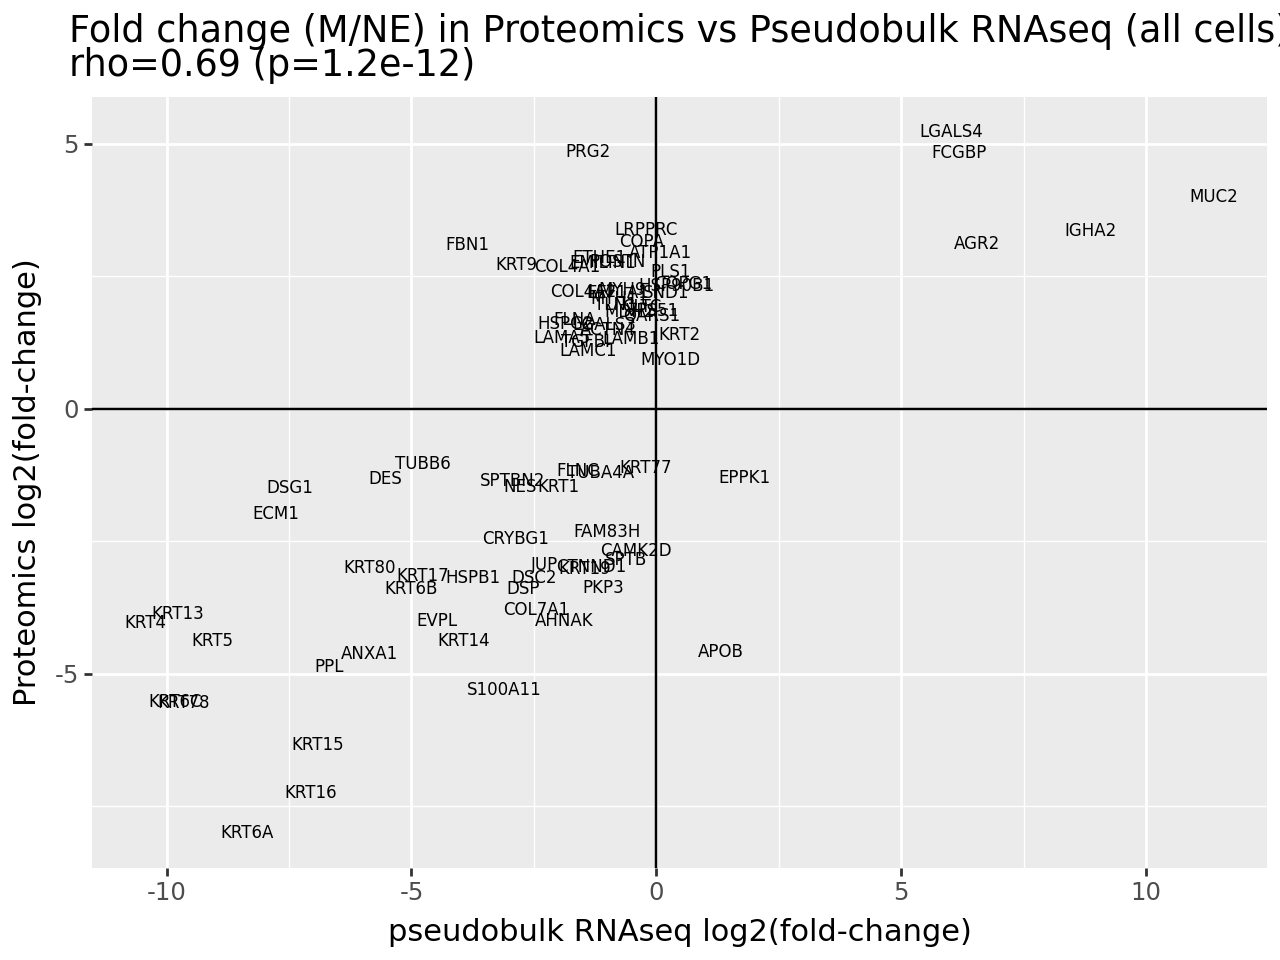

In [26]:
df_FC_sc_proteomics = _FC_pseudobulk_df\
 .merge(df_NE_vs_M.rename({'log2fc': 'log2fc_proteomics', 'qvalue': 'qvalue_proteomics'}, axis=1), on='gene')#\

from scipy.stats import spearmanr
rho, pval_rho = spearmanr(
    np.log2(df_FC_sc_proteomics.ratio_scrnaseq),
    df_FC_sc_proteomics.log2fc_proteomics)


p = pn.ggplot(df_FC_sc_proteomics,
          pn.aes('np.log2(ratio_scrnaseq)', 'log2fc_proteomics', label='gene' ))\
+ pn.geom_text(size=6) + pn.geom_vline(xintercept=0) + pn.geom_hline(yintercept=0)\
+ pn.labs(title=f'Fold change (M/NE) in Proteomics vs Pseudobulk RNAseq (all cells)\nrho={rho:.2f} (p={pval_rho:.1e})', x='pseudobulk RNAseq log2(fold-change)', y='Proteomics log2(fold-change)')
p.save(f'{plotfolder}/ECM_FC_comparison.svg')
p

In [27]:
df_FC_sc_proteomics.query('gene=="POSTN"')

,index,delta_expression_scrnaseq,NE_expression_scrnaseq,T_expression_scrnaseq,ratio_scrnaseq,gene,log2fc_proteomics,qvalue_proteomics,Comparison (group1/group2),# of Ratios,Pvalue,up_or_down,Pvalue_clipped
31,31,-603458.5,1422421.0,818962.5,0.575753,POSTN,2.78,1.750000e-32,M / MaN,355,6.710000e-35,up,6.710000e-35


## Using Deseq to get FCs

In [28]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [29]:
pdata = dc.get_pseudobulk(A.raw.to_adata(),
                          sample_col='samplename',
                          groups_col='diagnosis',#'celltype_split',
                          mode='sum',
                          min_cells=50,
                         )
pdata

AnnData object with n_obs × n_vars = 10 × 28584
    obs: 'samplename', 'diagnosis', 'patient', 'procedure', 'dataset', 'psbulk_n_cells', 'psbulk_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'is_mito', 'is_ribo', 'old_genename'
    layers: 'psbulk_props'

### ACtual DE
#### with patient 

In [30]:
dds = DeseqDataSet(
    adata=pdata.copy(),
    design_factors=['patient','diagnosis'],
    refit_cooks=True,
    n_cpus=8,
)
dds.deseq2()

stats_res = DeseqStats(dds, contrast=["diagnosis",  "M", "NE"])
stats_res.summary()
df_DE= stats_res.results_df


stats_res = DeseqStats(dds, contrast=["diagnosis",  "M", "NE"])
stats_res.summary()
stats_res.lfc_shrink(coeff='diagnosis_NE_vs_M')
df_DE_shrink= stats_res.results_df

# somehow the lfc is the wrong way around
df_DE_shrink.log2FoldChange = -df_DE_shrink.log2FoldChange

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.78 seconds.

Fitting dispersion trend curve...
/opt/conda/lib/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.66 seconds.

Fitting MAP dispersions...
... done in 7.27 seconds.

Fitting LFCs...
... done in 5.55 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 6.00 seconds.



Log2 fold change & Wald test p-value: diagnosis M vs NE
           baseMean  log2FoldChange     lfcSE      stat        pvalue  \
A1BG     309.464564       -0.512409  0.240666 -2.129128  3.324369e-02   
A1CF     295.555810        3.855980  0.582871  6.615497  3.703051e-11   
A2M     2078.610044       -1.246957  0.677693 -1.840003  6.576776e-02   
A2ML1   1375.392936       -5.476069  0.602371 -9.090851  9.826698e-20   
A2MP1     10.599266       -0.953595  0.617359 -1.544636  1.224342e-01   
...             ...             ...       ...       ...           ...   
ZYG11A    43.120701       -0.350912  0.363174 -0.966235  3.339266e-01   
ZYG11B   444.263504       -0.164399  0.174346 -0.942950  3.457062e-01   
ZYX      692.997782        0.203912  0.349867  0.582826  5.600103e-01   
ZZEF1    396.206606        0.577635  0.348583  1.657092  9.750093e-02   
ZZZ3     300.004867        0.235863  0.231426  1.019172  3.081213e-01   

                padj  
A1BG    1.217368e-01  
A1CF    1.730770e-09 

Running Wald tests...
... done in 2.01 seconds.



Log2 fold change & Wald test p-value: diagnosis M vs NE
           baseMean  log2FoldChange     lfcSE      stat        pvalue  \
A1BG     309.464564       -0.512409  0.240666 -2.129128  3.324369e-02   
A1CF     295.555810        3.855980  0.582871  6.615497  3.703051e-11   
A2M     2078.610044       -1.246957  0.677693 -1.840003  6.576776e-02   
A2ML1   1375.392936       -5.476069  0.602371 -9.090851  9.826698e-20   
A2MP1     10.599266       -0.953595  0.617359 -1.544636  1.224342e-01   
...             ...             ...       ...       ...           ...   
ZYG11A    43.120701       -0.350912  0.363174 -0.966235  3.339266e-01   
ZYG11B   444.263504       -0.164399  0.174346 -0.942950  3.457062e-01   
ZYX      692.997782        0.203912  0.349867  0.582826  5.600103e-01   
ZZEF1    396.206606        0.577635  0.348583  1.657092  9.750093e-02   
ZZZ3     300.004867        0.235863  0.231426  1.019172  3.081213e-01   

                padj  
A1BG    1.217368e-01  
A1CF    1.730770e-09 

Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: diagnosis NE vs M
           baseMean  log2FoldChange     lfcSE      stat        pvalue  \
A1BG     309.464564        0.462212  0.226328 -2.129128  3.324369e-02   
A1CF     295.555810       -3.633221  0.700060  6.615497  3.703051e-11   
A2M     2078.610044        0.757904  0.649986 -1.840003  6.576776e-02   
A2ML1   1375.392936        5.344953  0.695633 -9.090851  9.826698e-20   
A2MP1     10.599266        0.586345  0.526331 -1.544636  1.224342e-01   
...             ...             ...       ...       ...           ...   
ZYG11A    43.120701        0.271867  0.304809 -0.966235  3.339266e-01   
ZYG11B   444.263504        0.155410  0.165790 -0.942950  3.457062e-01   
ZYX      692.997782       -0.155295  0.305120  0.582826  5.600103e-01   
ZZEF1    396.206606       -0.464454  0.322641  1.657092  9.750093e-02   
ZZZ3     300.004867       -0.212639  0.212878  1.019172  3.081213e-01   

                padj  
A1BG    1.217368e-01  
A1CF    1.7307

... done in 4.59 seconds.



## Plots

In [31]:
from ecm_tools import plot_fc_comparision

~patient + diag, unshrubk

In [32]:
all_genes = [_ for _ in genes_up+genes_down if _ in df_DE.index.values]
len(all_genes), len(genes_up+genes_down)

(79, 80)

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 5 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_M/ECM_FC_comparison_unshrunk_patient_diag.svg


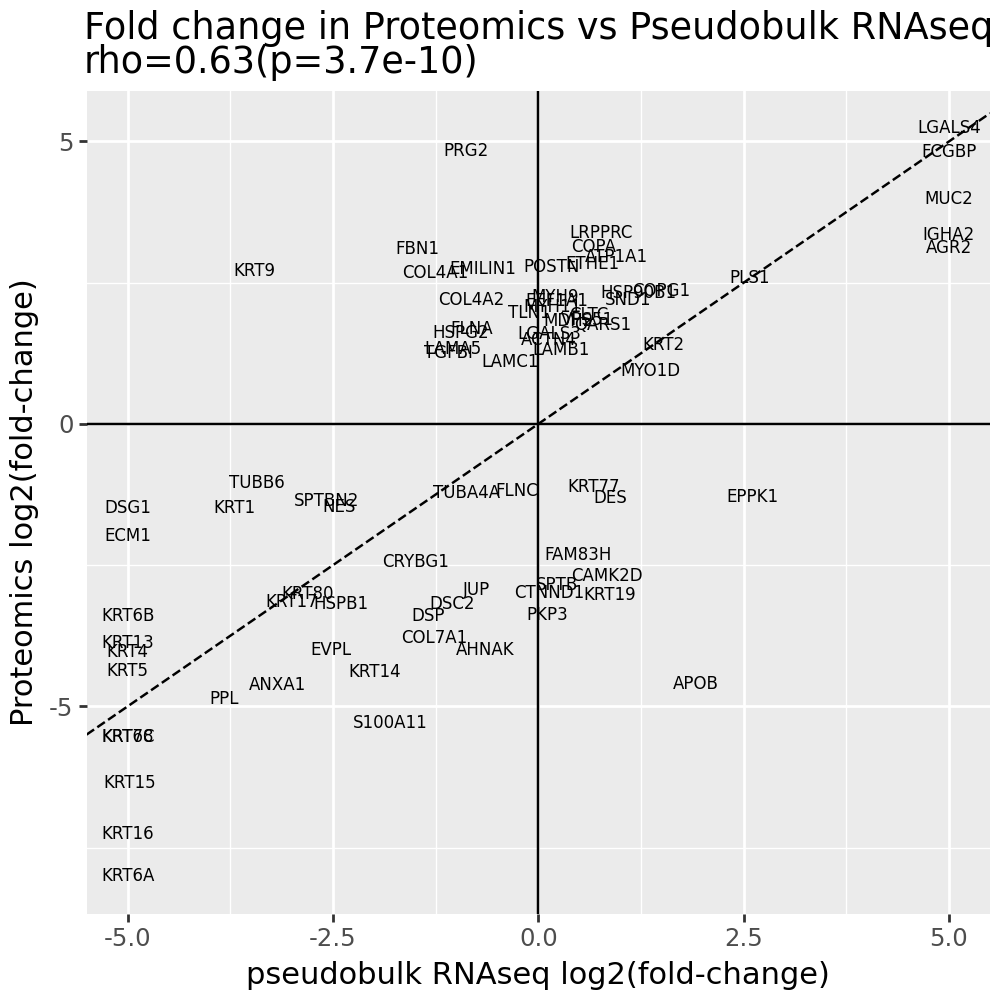

In [33]:
df = df_DE.merge(df_NE_vs_M.set_index('gene'), left_index=True, right_index=True).loc[all_genes]
p = plot_fc_comparision(df, ) + pn.theme(figure_size=(5,5))
p.save(f'{plotfolder}/ECM_FC_comparison_unshrunk_patient_diag.svg')

p

~patient + diag, with shrinkage

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 5 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_M/ECM_FC_comparison_shrunk_patient_diag.svg


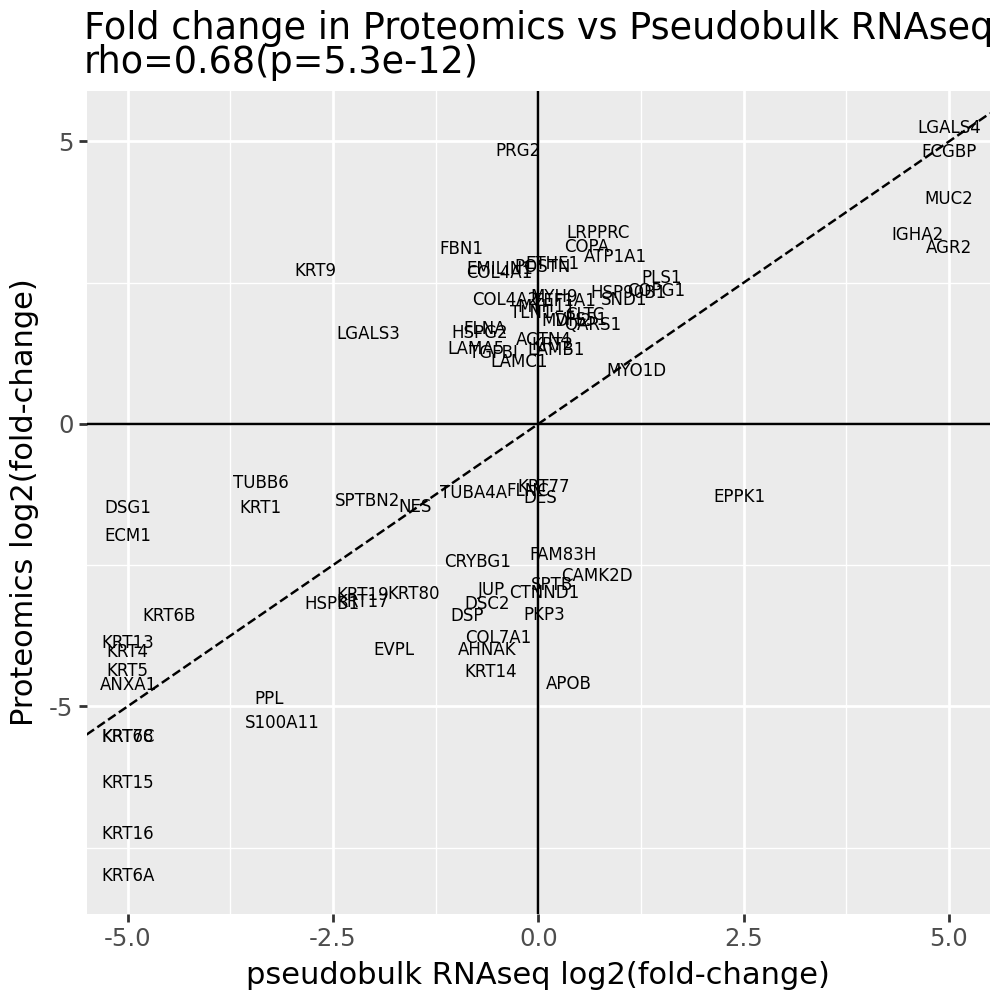

In [34]:
df = df_DE_shrink.merge(df_NE_vs_M.set_index('gene'), left_index=True, right_index=True).loc[all_genes]
p = plot_fc_comparision(df)+ pn.theme(figure_size=(5,5))
p.save(f'{plotfolder}/ECM_FC_comparison_shrunk_patient_diag.svg')
p

# Fold change by cell type

In [35]:
from ecm_tools import suis_plot_fixed, ecm_lfc_via_deseq_python

In [36]:
from ecm_tools import the_plot_shrunk, the_plot_unshrunk, ecm_lfc_via_deseq_python

In [37]:
colormap = pn.scale_color_manual(color_dict_coarse_celltype)
theme =  pn.theme(figure_size=(5,9), panel_background=pn.element_rect(fill='white', alpha=.2), line=pn.element_line(color='grey'))

## DEseq fold changes
A general problem seems to be very low abundance, but still DE, probably due to ambient RNA. Lets filter out low abundance

In [38]:
A.obs.diagnosis = pd.Categorical(A.obs.diagnosis, ['NE','M'])

In [39]:
A.obs['celltype_merge_epi']=A.obs['celltype_split'].astype(str)
A.obs['celltype_merge_epi'].replace({'Columnar Epithelium': 'Epithelium','Squamous Epithelium': "Epithelium"}, inplace=True)

### ~patient+diagnosis

In [40]:
contrast = ["diagnosis",  "NE", "M"]
design_factors = ['patient','diagnosis']
df_de_all, adata_vsds =  ecm_lfc_via_deseq_python(A, design_factors, contrast=contrast, gene_min_counts=10)
df_de_all['independent_filter'] = df_de_all.padj.apply(lambda x: 'filtered' if np.isnan(x) else 'ok')

Celltype: Tcells


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.87 seconds.

Fitting dispersion trend curve...
... done in 0.50 seconds.

Fitting MAP dispersions...
... done in 2.34 seconds.

Fitting LFCs...
... done in 2.41 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



Fit type used for VST : parametric


Fitting dispersions...
... done in 1.68 seconds.



Celltype: Epithelium


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 3.85 seconds.

Fitting dispersion trend curve...
... done in 0.93 seconds.

Fitting MAP dispersions...
... done in 4.03 seconds.

Fitting LFCs...
... done in 3.98 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.



Fit type used for VST : parametric


Fitting dispersions...
... done in 3.30 seconds.



Celltype: Mast cells


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.60 seconds.

Fitting dispersion trend curve...
... done in 0.97 seconds.

/opt/conda/lib/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
Fitting MAP dispersions...
... done in 2.20 seconds.

Fitting LFCs...
... done in 2.53 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))


Fit type used for VST : parametric


Fitting dispersions...
... done in 1.25 seconds.



Celltype: Fibroblasts


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.96 seconds.

Fitting dispersion trend curve...
... done in 0.77 seconds.

Fitting MAP dispersions...
... done in 3.27 seconds.

Fitting LFCs...
... done in 3.05 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size

Fit type used for VST : parametric


Fitting dispersions...
... done in 1.51 seconds.



Celltype: Myofibroblasts


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.63 seconds.

Fitting dispersion trend curve...
... done in 0.24 seconds.

/opt/conda/lib/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
Fitting MAP dispersions...
... done in 0.89 seconds.

Fitting LFCs...
... done in 1.36 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarn

Fit type used for VST : parametric


Fitting dispersions...
... done in 1.32 seconds.



Celltype: Endothelial cells


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.78 seconds.

Fitting dispersion trend curve...
... done in 0.76 seconds.

/opt/conda/lib/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
Fitting MAP dispersions...
... done in 2.43 seconds.

Fitting LFCs...
... done in 2.82 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarn

Fit type used for VST : parametric


Fitting dispersions...
... done in 1.95 seconds.



Celltype: Myeloid


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 2.74 seconds.

Fitting dispersion trend curve...
... done in 0.88 seconds.

Fitting MAP dispersions...
... done in 2.30 seconds.

Fitting LFCs...
... done in 3.06 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size

Fit type used for VST : parametric


Fitting dispersions...
... done in 1.89 seconds.



Celltype: Bcells


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 2.76 seconds.

Fitting dispersion trend curve...
/opt/conda/lib/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 0.26 seconds.

/opt/conda/lib/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
Fitting MAP dispersions...
... done in 2.16 seconds.

Fitting LFCs...
... done in 2.29 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning

Fit type used for VST : parametric


Fitting dispersions...
... done in 1.44 seconds.



Celltype: Other


In [41]:
df_de_all.loc['MUC2']

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,log2FoldChange_shrunk,lfcSE_shrunk,celltype,independent_filter
MUC2,16.321445,-8.039443,2.013137,-3.993491,6.510756e-05,5.188473e-03,-8.741479e+00,2.851475,Tcells,ok
MUC2,3046.148879,-11.877393,1.242964,-9.555704,1.227460e-21,9.646849e-20,-1.230328e+01,1.500592,Epithelium,ok
MUC2,5.803028,-6.316262,2.412345,-2.618308,8.836702e-03,5.068465e-01,-8.532899e-03,0.059665,Mast cells,ok
MUC2,8.102735,-8.054067,1.538560,-5.234808,1.651568e-07,5.777184e-05,-1.036536e+01,3.080283,Fibroblasts,ok
MUC2,1.319802,-3.586846,3.434618,-1.044322,2.963366e-01,9.999551e-01,-3.935995e-07,0.003916,Myofibroblasts,ok
MUC2,8.730831,-8.270196,1.936884,-4.269845,1.956086e-05,4.920282e-03,-9.158210e+00,2.877004,Endothelial cells,ok
MUC2,5.722880,-6.248949,1.796106,-3.479166,5.029773e-04,9.008882e-02,-3.067449e-06,0.001219,Myeloid,ok
MUC2,13.855176,-3.803290,2.123852,-1.790751,7.333331e-02,9.995243e-01,-7.145511e-07,0.001467,Bcells,ok


#### unshrunk

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 9 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_M/ECM_DESeq_FC_per_celltype_down_patient_diag_unshrunk_baseMean.svg


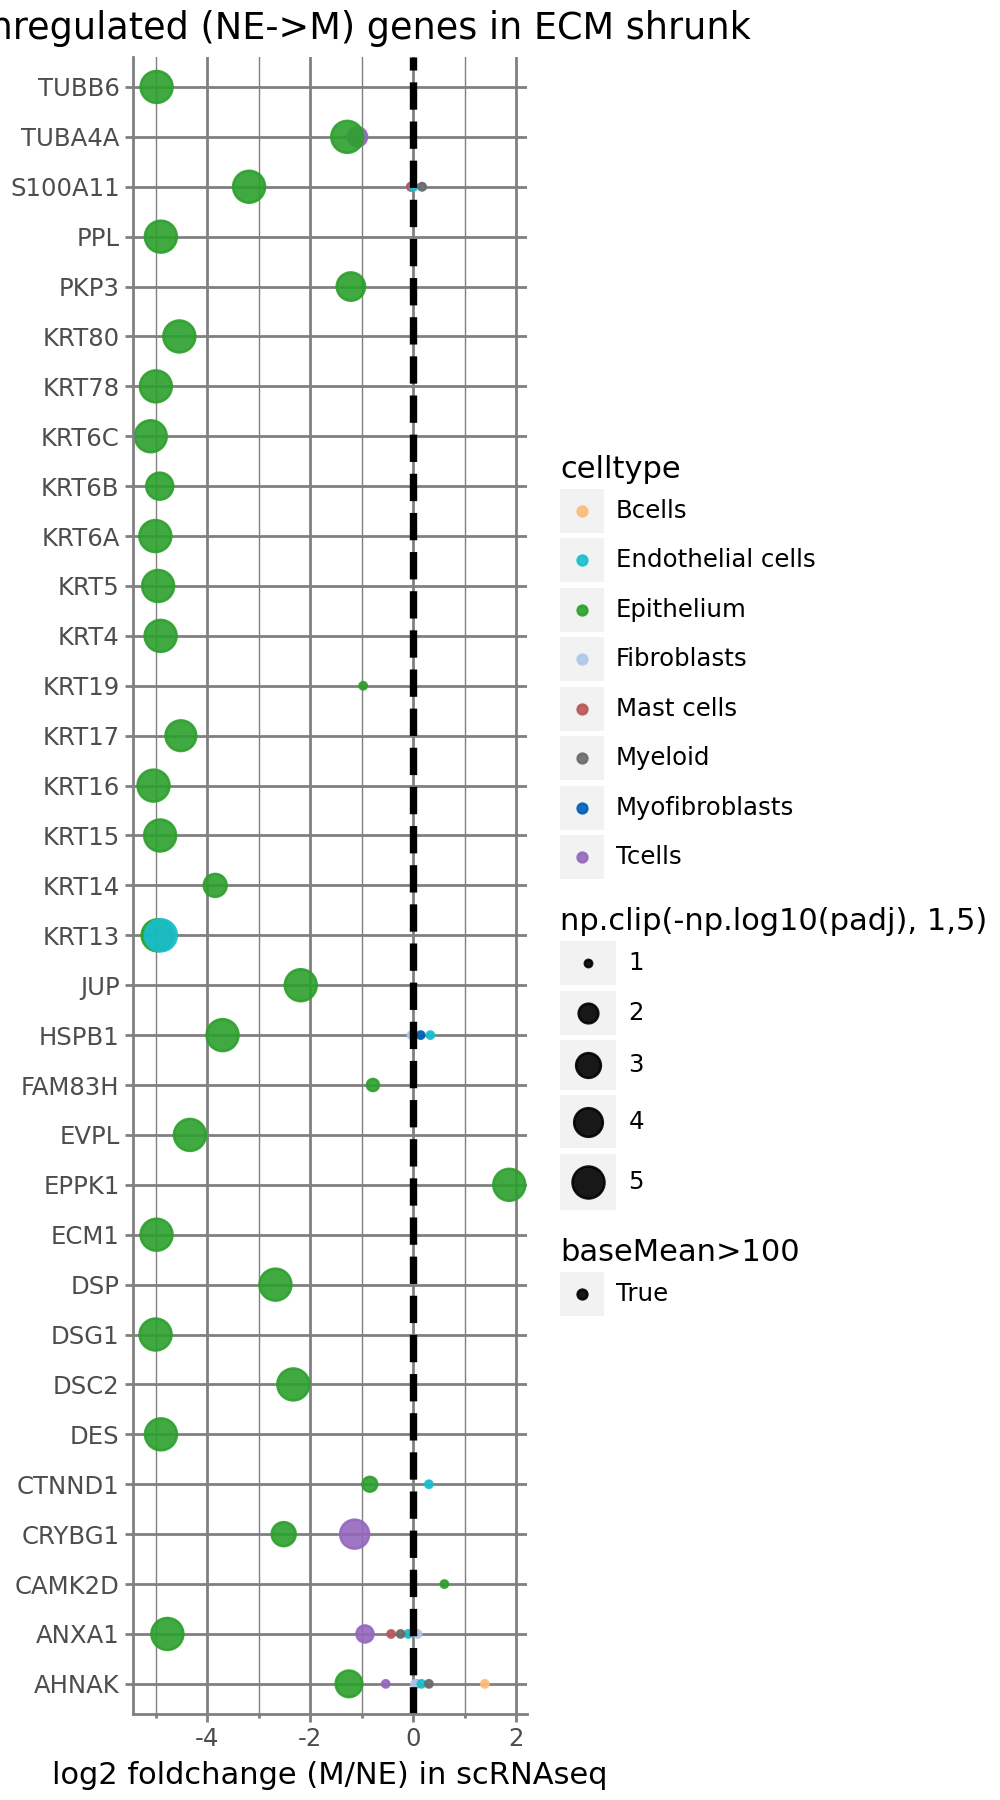

In [42]:
p2 = the_plot_unshrunk(df_de_all.loc[[_ for _ in genes_down if _ in  df_de_all.index]].reset_index().query("baseMean>100")) + pn.labs(x='log2 foldchange (M/NE) in scRNAseq', title='Downregulated (NE->M) genes in ECM shrunk', y='')
p2.save(f'{plotfolder}/ECM_DESeq_FC_per_celltype_down_patient_diag_unshrunk_baseMean.svg')
p2.show()

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 9 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_M/ECM_DESeq_FC_per_celltype_up_patient_diag_unshrunk_baseMean.svg


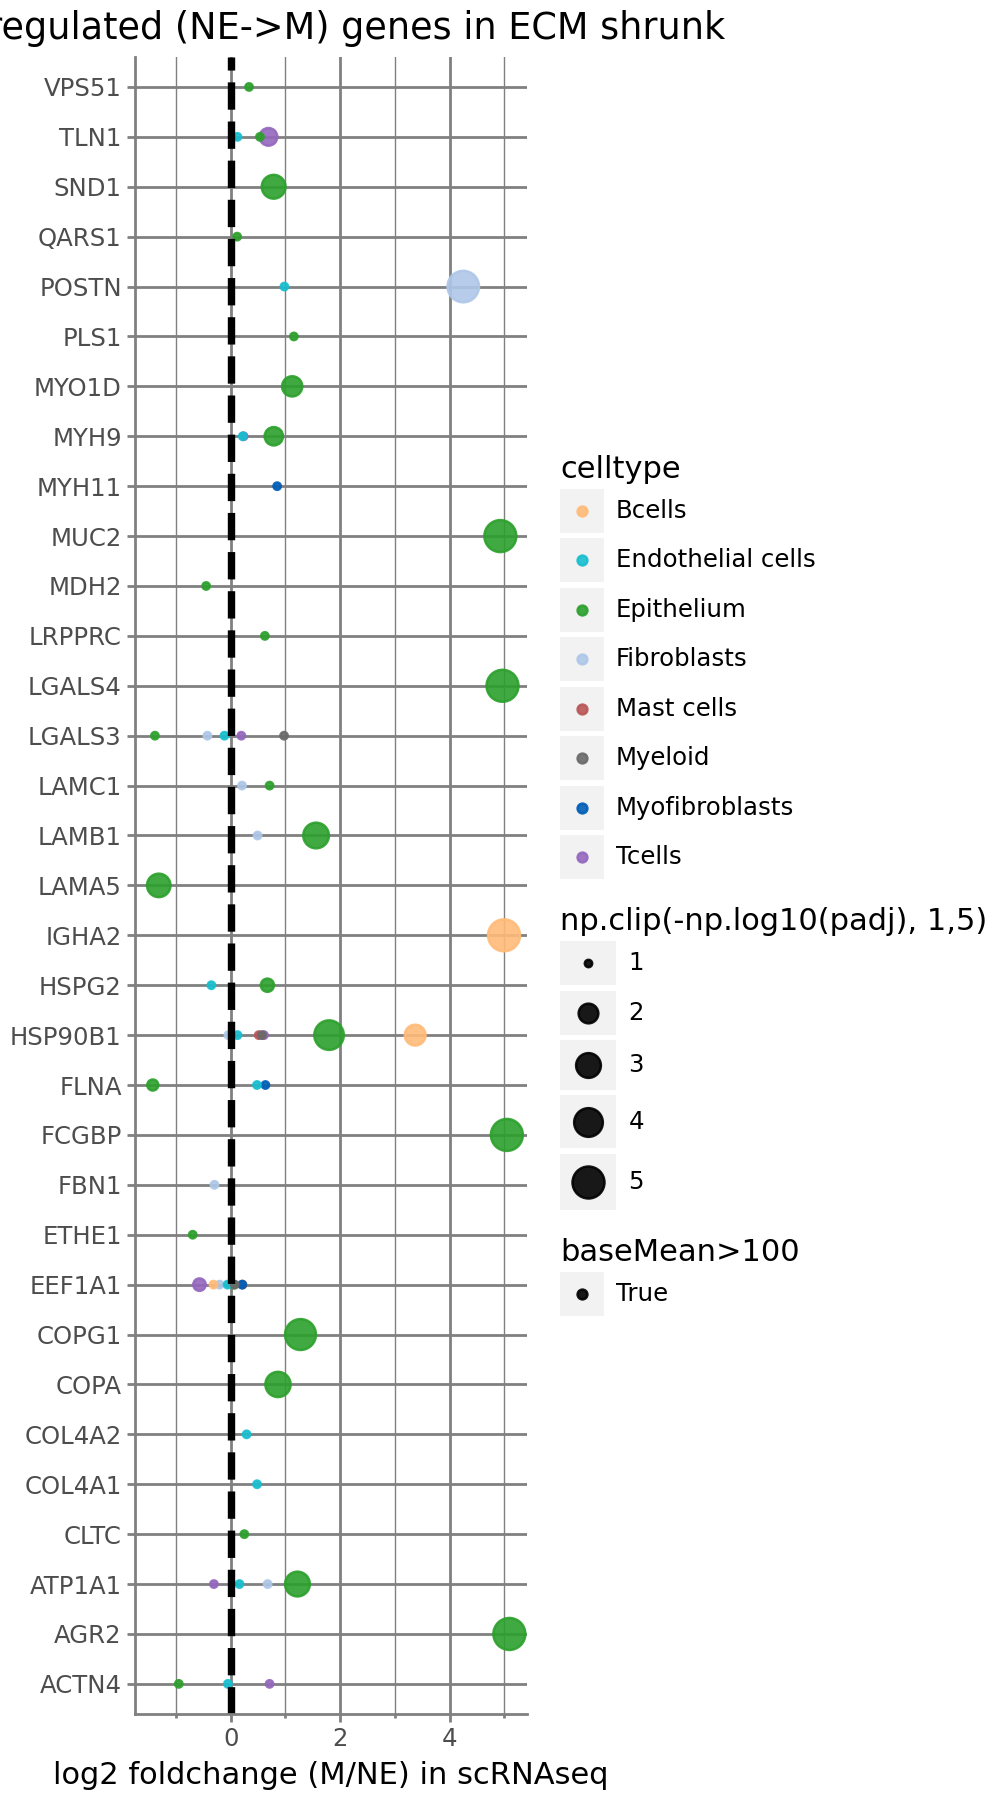

In [43]:
p2 = the_plot_unshrunk(df_de_all.loc[[_ for _ in genes_up if _ in  df_de_all.index]].reset_index().query("baseMean>100")) + pn.labs(x='log2 foldchange (M/NE) in scRNAseq', title='Upregulated (NE->M) genes in ECM shrunk', y='')
p2.save(f'{plotfolder}/ECM_DESeq_FC_per_celltype_up_patient_diag_unshrunk_baseMean.svg')
p2.show()

In [44]:
from ecm_tools import plot_gene

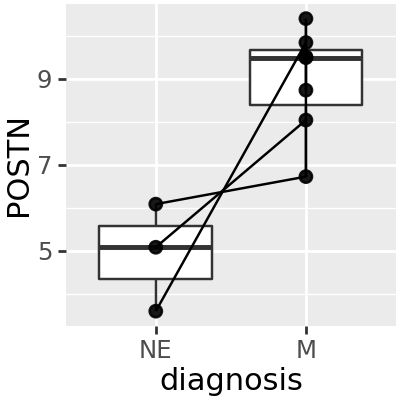

In [45]:
gene = 'POSTN'
ct = 'Fibroblasts'
_avsd = adata_vsds[ct].copy()
_avsd.obs.diagnosis= pd.Categorical(_avsd.obs.diagnosis, ['NE','M'])
plot_gene(gene, _avsd, grouping_var='diagnosis') + pn.theme(figure_size=(2,2))

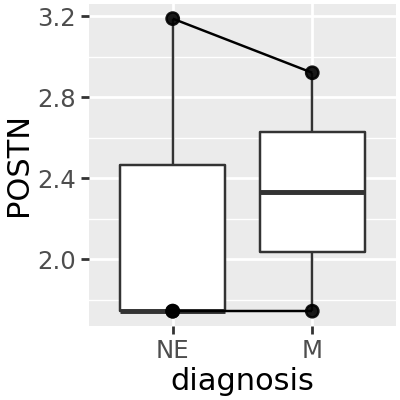

In [46]:
ct = 'Myofibroblasts'
_avsd = adata_vsds[ct].copy()
_avsd.obs.diagnosis= pd.Categorical(_avsd.obs.diagnosis, ['NE','M'])
plot_gene(gene, _avsd, grouping_var='diagnosis') + pn.theme(figure_size=(2,2))

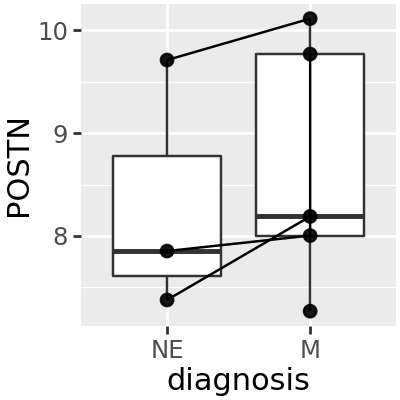

In [47]:
ct = 'Endothelial cells'
_avsd = adata_vsds[ct].copy()
_avsd.obs.diagnosis= pd.Categorical(_avsd.obs.diagnosis, ['NE','M'])
plot_gene(gene, _avsd, grouping_var='diagnosis') + pn.theme(figure_size=(2,2))

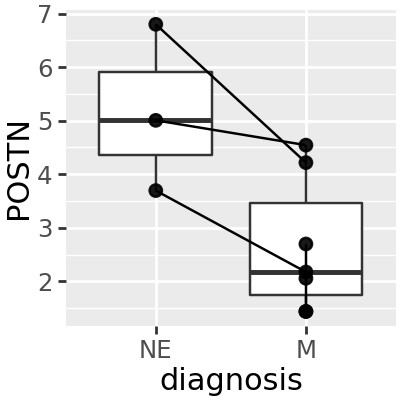

In [48]:
ct = 'Epithelium'
_avsd = adata_vsds[ct].copy()
_avsd.obs.diagnosis= pd.Categorical(_avsd.obs.diagnosis, ['NE','M'])
plot_gene(gene, _avsd, grouping_var='diagnosis') + pn.theme(figure_size=(2,2))

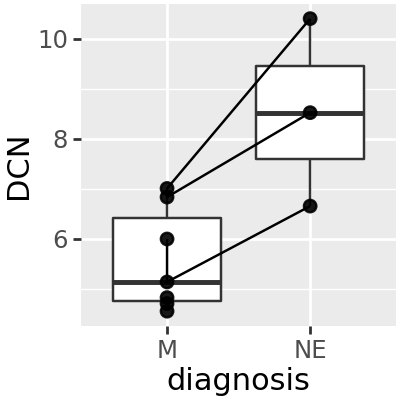

In [49]:
plot_gene('DCN', adata_vsds[ct], grouping_var='diagnosis') + pn.theme(figure_size=(2,2))